In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.model import Model
from gallifrey.utilities.math import calculate_pca
from gallifrey.utilities.dataframe import (
    aggregated_dataframe,
    rename_labels,
    rename_galaxy_components,
)
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    adjust_legend,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo


      DETECTED LOCAL MACHINE: Test snapshot loaded.


      CONFIG: Setting resolution to 4096.


      CONFIG: Setting snapshot to 127.


      CONFIG: Setting sim_id to 09_18.

yt : [INFO     ] 2023-10-17 16:06:19,987 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-10-17 16:06:20,043 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-10-17 16:06:20,044 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-10-17 16:06:20,044 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-17 16:06:20,044 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-10-17 16:06:20,045 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-17 16:06:20,045 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-10-17 16:06:20,045 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-10-17 16:06:20,046 Parameters: omega_matter 

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Component_populations"
save = True

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()

components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]

## OCCURENCE RATES PER COMPONENT

In [8]:
def calculate_occurence_rates(host_star_mass):
    model.update_fields(ngpps_star_masses=host_star_mass)

    sphere_data = mw.sphere(radius=radius)

    data = aggregated_dataframe(
        components,
        ["planet_hosting_number", *planet_categories],
        data_source=sphere_data,
        type_name="Component",
    )

    # rename components
    data = rename_galaxy_components(data)

    number_of_planets = data.groupby("Component")[planet_categories].sum()
    number_of_host_stars = data.groupby("Component")["planet_hosting_number"].sum()
    occurence_rate = number_of_planets.div(number_of_host_stars, axis=0).reset_index()

    occurence_rate_long_format = occurence_rate.melt(
        id_vars="Component",
        var_name="Planet Type",
        value_name="Occurence Rate",
    )
    return occurence_rate_long_format


      CONFIG: Setting ngpps_star_masses to 0.1.


      TIMER: Block 'Adding Planets...' took 1.09 seconds.


      CONFIG: Setting ngpps_star_masses to 0.5.


      TIMER: Block 'Adding Planets...' took 1.2 seconds.


      CONFIG: Setting ngpps_star_masses to 1.


      TIMER: Block 'Adding Planets...' took 1.02 seconds.



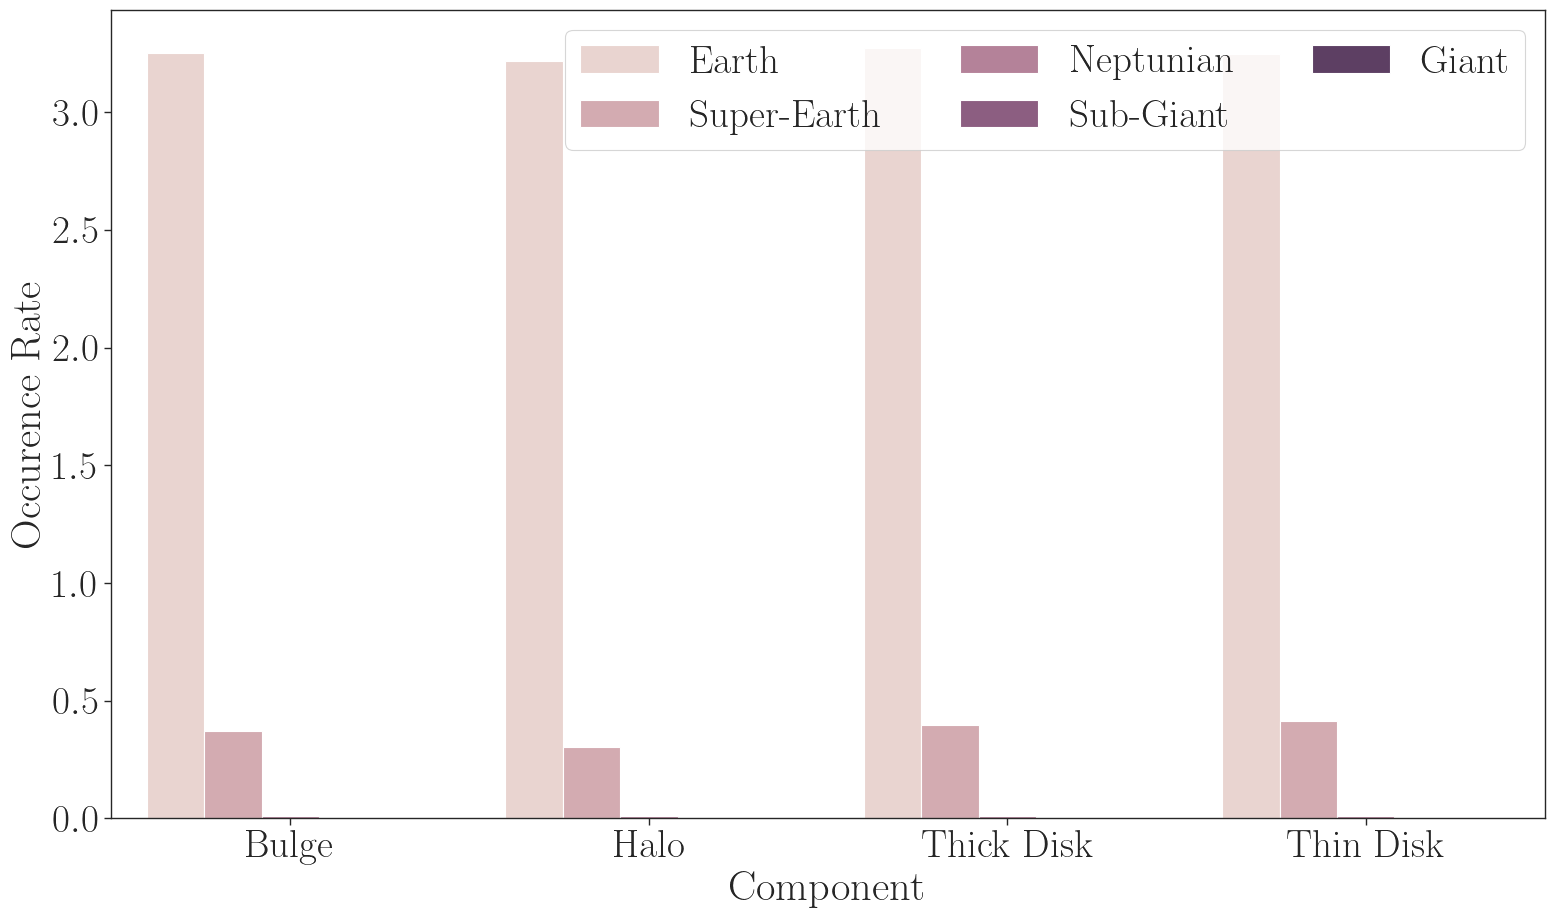

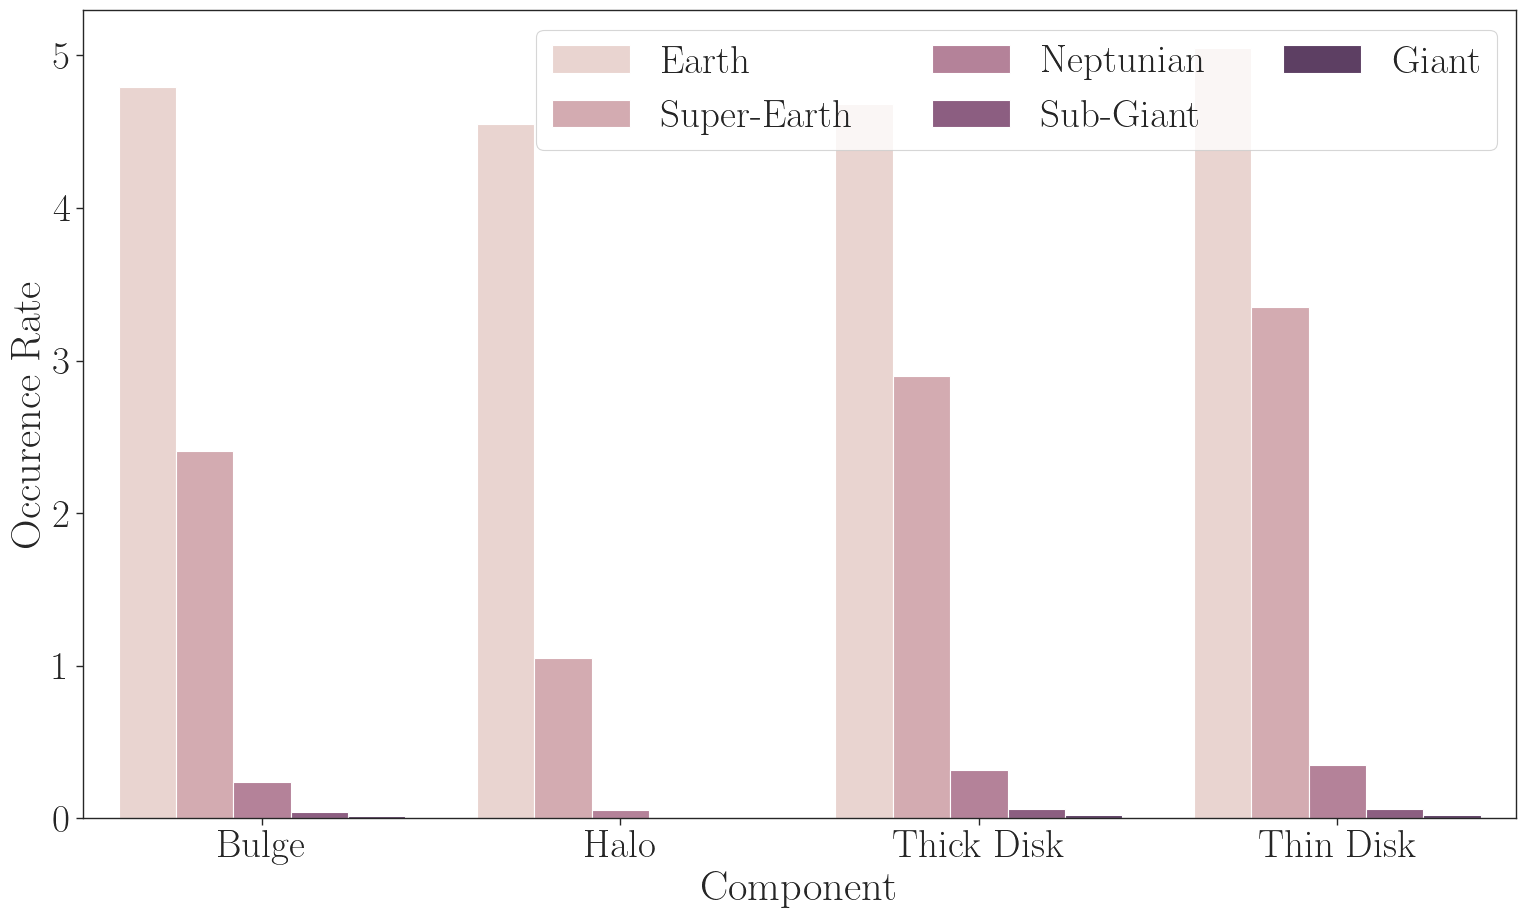

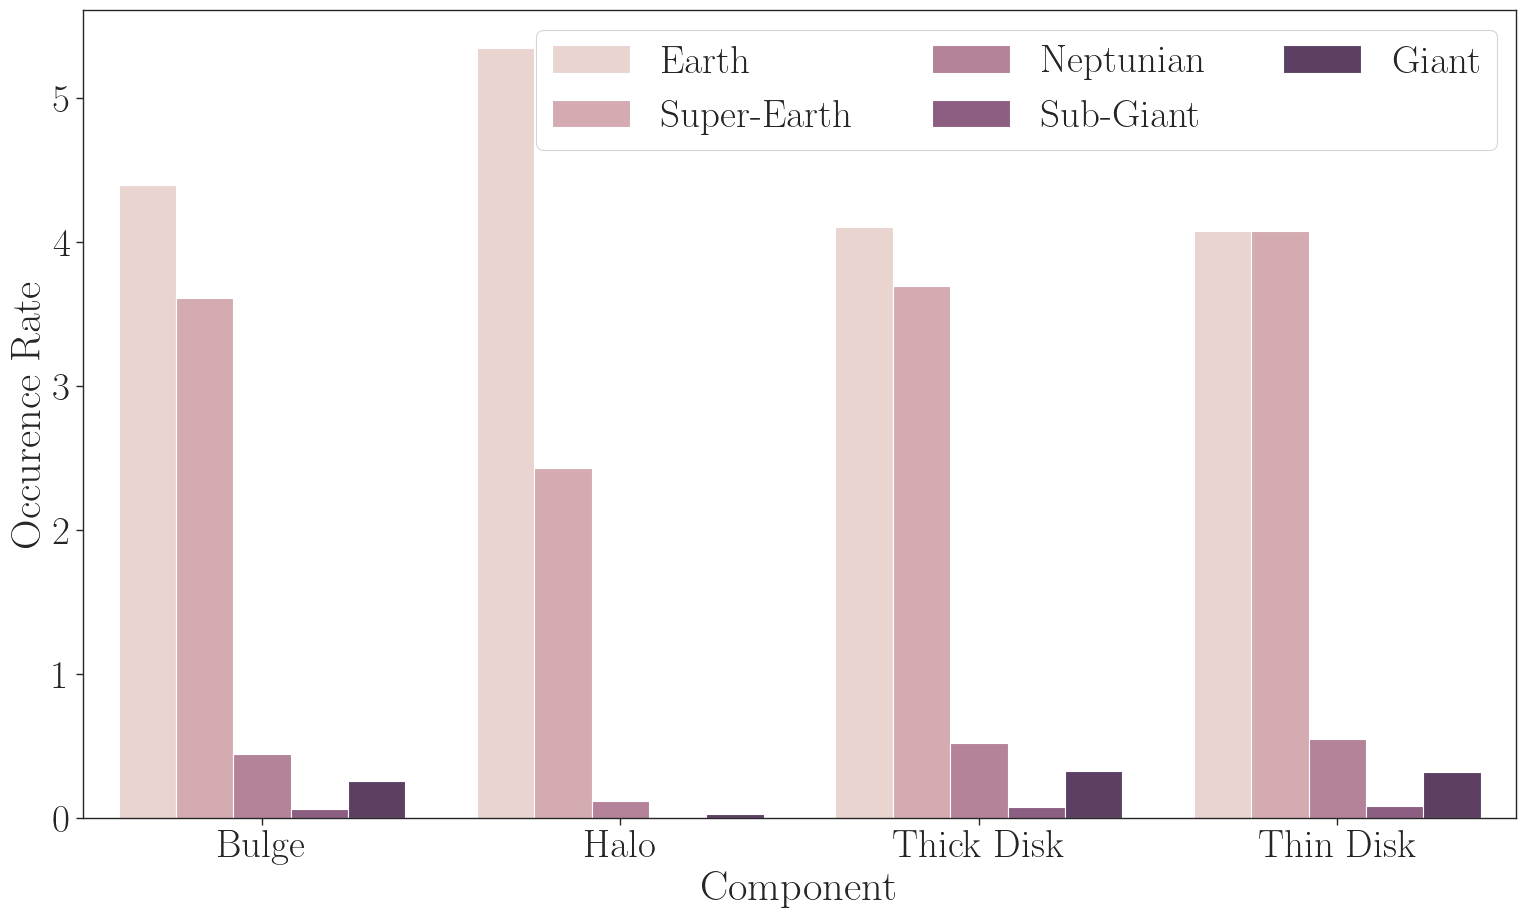

In [9]:
def barplot(occurence_rate_long_format, host_star_mass):
    plt.figure()
    with sns.axes_style("ticks"):
        occurence_rate_barplot = sns.barplot(
            data=occurence_rate_long_format,
            x="Component",
            y="Occurence Rate",
            hue="Planet Type",
            log=False,
            palette=get_palette(),
        )
    # adjust legend
    occurence_rate_barplot = adjust_legend(occurence_rate_barplot, pad=1)

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_host_star_mass_={host_star_mass}.pdf",
        sub_directory=figure_subdirectory,
        save=save,
    )


masses = (0.1, 0.5, 1)
for m in masses:
    occurence_rate_long_format = calculate_occurence_rates(host_star_mass=m)
    barplot(occurence_rate_long_format, host_star_mass=m)